# Linear regression and basis functions

**Contents**

1. Load datasets
2. Univariate multiple linear regression
   1. Idea
   2. Finding the best straight line
   3. Notations for univariate, multiple linear regression
   4. Illustration: Univariate simple linear regression
   5. Simple linear regression on non-linear data
3. Basis functions
   1. Linear regression with polynomial basis functions
   2. Linear regression with polynomial basis functions on non-polynomial data
   3. Linear regression with cosine basis functions
   4. Linear regression with gaussian basis functions
4. Choose the right basis functions and the right parameters: model selection and evaluation
   1. Model selection
   2. Model evaluation


In [1]:
import numpy as np 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### 1. Load datasets

In [2]:
data01 = np.load("data/data01.npy")
X01, Y01 = data01[:,0], data01[:,1]
data02 = np.load("data/data02.npy")
X02, Y02 = data02[:,0], data02[:,1]
data03 = np.load("data/data03.npy")
X03, Y03 = data03[:,0], data03[:,1]
data04 = np.load("data/data04.npy")
X04, Y04 = data04[:,0], data04[:,1]

def sort_wrt_x_axis(X,Y, return_idx=False):
    """
    Sort X and Y with respect to X, usefull for better plots
    """
    idx = np.argsort(X)
    if return_idx:
        res = (X[idx], Y[idx], idx)
    else:
        res = (X[idx], Y[idx])
    return res

### 2. Univariate multiple linear regression

#### 2.1 Idea

Given a point cloud defined by $n$ pairs $(\mathbf{x_i}, y_i)$ where $\mathbf{x_i} \in \mathbb{R}^{d} $ are features (or predictors) and $y_i \in \mathbb{R}$ are observed values.
The objective of univariate linear regression is to find the straight line that best fits to this point cloud, i.e find the line's parameters $\mathbf{w} \in \mathbb{R}^{d} $ (for *weights*) such that $\textrm{SSE} = \sum_i \epsilon_i^2$ is minimal, with 

$$y_i = \mathbf{w}^T \mathbf{x_i}  + \epsilon_i$$

The term *univariate* refers to each $y_i$ being scalars, and the term *multiple* refers to each $\mathbf{x_i}$ being vectors.

#### 2.2 Finding the best straight line

By computing the gradient, setting it to $0$ and solving the equation, we can show that this $\textrm{SSE}$ error is minimal for $$\hat{\mathbf{w}} = \mathbf{X}^+\mathbf{y}$$ where $\mathbf{X}^+$ is the pseudo-inverse of $\mathbf{X}$, i.e  $\mathbf{X}^+ = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T$

Once $\hat{w}$ has been computed, it can be used on new feature values $\mathbf{X}_{new}$ to predict $\mathbf{y}_{pred}$ with $$\mathbf{y}_{pred} = \hat{\mathbf{w}}^T \mathbf{X}_{new}$$

#### 2.3 Notations for **univariate**, **multiple** linear regression

- $n$ input vectors $\mathbf{x}_{i=1..n}$ in a $d+1$ dimensional space representing $n$ samples of $d$ features (+ 1 dummy variable for the biais, also called intercept) , i.e 

\begin{equation}
\mathbf{x}_i = \begin{bmatrix}1, x_{i,1}, x_{i,2}, \cdots, x_{i,d}\end{bmatrix}^T \in \mathbb{R}^{d}  \qquad \textrm{and}  \;
\mathbf{X} = 
\begin{bmatrix}
1 & x_{1,1} & x_{1,2} & \cdots & x_{1, d} \\
1 & x_{2,1} & x_{2,2} & \cdots & x_{2, d} \\
\vdots & \vdots  & \vdots  & \ddots & \vdots  \\
1 & x_{n,1} & x_{n,2} & \cdots & x_{n, d}
\end{bmatrix} \in \mathbb{R}^{(n, d+1)}
\end{equation}

- $n$ output values $\mathbf{y}_{i=1..n}$ (one for each input) representing $n$ observations in $\mathbb{R}$

\begin{equation}
\mathbf{y} = 
\begin{bmatrix}y_{1}, y_{2}, \cdots,y_{n}
\end{bmatrix}^T \in \mathbb{R}^{n}
\end{equation}

- $d+1$ unknown parameters or regression coefficients $\mathbf{w}_{k=0..d}$ (one for each feature + biais) representing the slope associated to the $k^{th}$ feature

\begin{equation}
\mathbf{w} = 
\begin{bmatrix}w_{0}, w_{1}, \cdots & w_{d} \end{bmatrix}^T\in \mathbb{R}^{d+1}
\end{equation}

In [3]:
def add_dummy_variable(x):
    return np.column_stack([np.ones(len(x)), x])

def fit_LR(x,y, add_biais=True):
    """
    Solve the linear regression problem, i.e compute W_hat
    """
    # Add dummy variable if not already done
    if add_biais:
        x = add_dummy_variable(x)
    # Compute w = pseudo_inv(X) * y (using matrix multiplication)
    w = np.linalg.pinv(x) @ y
    return w

def predict_LR(x, w, add_biais=True):
    """
    Returns ``Y_pred`` given new features values and a weights
    """
    X = np.copy(x)
    # Add dummy variable if not already done
    if add_biais:
        X = add_dummy_variable(X)
    # Returns y_pred = W.T*X (using matrix multiplication)
    return np.array([w.T @ xi for xi in X])

#### 2.4 Illustration: Univariate simple linear regression

If $d$ = 1 (i.e one feature), the regression is simple.

Questions:

1. Datasets 
   1. Using the function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from scikit-learn library, split ``X01`` and ``Y01`` into 3 datasets, a training one, a validation one and a testing one with a ratio 0.6, 0.2, 0.2. **HINT**: take a look at how we did it in the solution of Homework 1!
   2. Print the length (number of datapoints) of each datasets using [len()](https://docs.python.org/3/library/functions.html#len) or [ndarray.shape](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.shape.html)
2. Fitting your model
   1. Call ``fit_LR`` on your training dataset to compute the weights (store them in ``W``)
   2. What do ``W[0]`` and ``W[1]`` represent?
3. Predictions
   1. Call  ``predict_LR`` on your validation dataset and store the output in ``Y01_pred``
4. Now using scikit-learn:
   1. Instantiate an object of the class [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn-linear-model-linearregression) from the scikit-learn library and call it ```regr```
   2. Apply the [fit()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit) method using your training dataset.
   3. Apply the [predict()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) method using your validation dataset.
   4. Take a look at how the mse (Mean Square Error) of ``Y01_pred`` is computed and then compute the mse of ``Y01_pred_scikit``
   5. Take a look at how how the coefficient of determination $R^2$ is computed and then compute $R^2$ of ``Y01_pred_scikit``. ([Wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_determination): "*$R^2$ is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).  It provides a measure of how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model"*)
   6. Compare with the Mean Square Error and the coefficient of determination of ``Y01_pred``. 

 ============ Split datasets ============
Datapoints used for training:    240
Datapoints used for validation:  80
Datapoints used for testing :    80
 ============ Using Formula ============
 --- Fit the linear model ---
W_0 : 3.73
W_1 : 2.03
Mean Square Error: 95.20
Coefficient of determination: 0.85


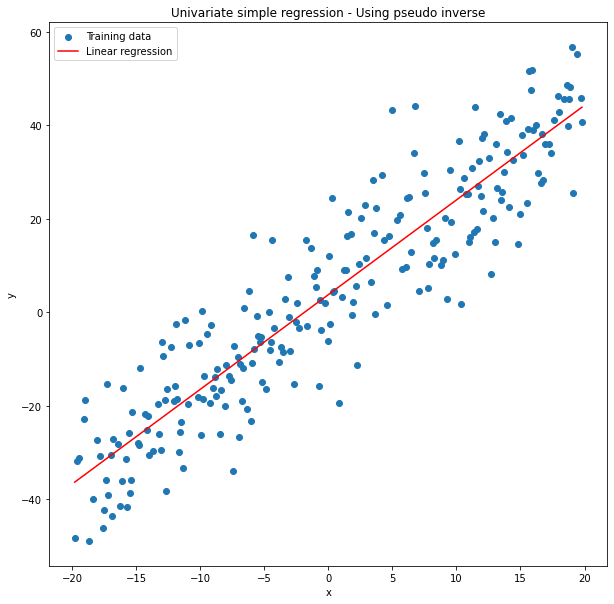

 --- Predictions ---
Mean Square Error: 93.13
Coefficient of determination: 0.86
 ============ Using scikit-learn ============ 
 --- Fit the linear model ---
W_0 : 3.73
W_1 : 2.03
 --- Predictions ---
Mean Square Error: 93.13
Coefficient of determination: 0.86


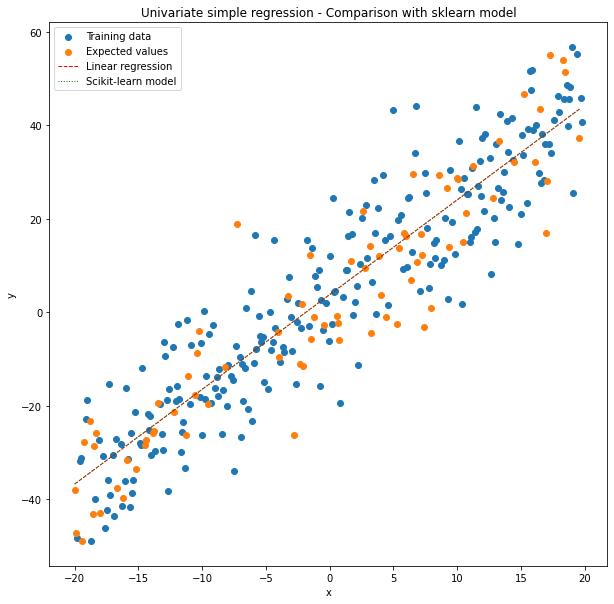

In [4]:
print(" ============ Split datasets ============")

# Fix random seed for reproducibility
seed = 666                    
# Shuffle and split the data into train and a concatenation of validation and test sets
X01_train, X01_val_test, Y01_train, Y01_val_test = train_test_split(X01, Y01, 
                                                                    test_size=0.4, 
                                                                    shuffle=True, 
                                                                    random_state=seed)

seed = 221
# Shuffle and split the data into validation and test sets
X01_val, X01_test, Y01_val, Y01_test = train_test_split(X01_val_test, Y01_val_test, 
                                                        test_size=0.5, 
                                                        shuffle=True, 
                                                        random_state=seed)                                                                            

# sort with respect to x_axis for better plots
X01_train, Y01_train = sort_wrt_x_axis(X01_train, Y01_train)
X01_val, Y01_val = sort_wrt_x_axis(X01_val, Y01_val)
X01_test, Y01_test = sort_wrt_x_axis(X01_test, Y01_test)


# Store number of datapoints in each dataset:
N_train = len(Y01_train)
N_val = len(Y01_val)
N_test = len(Y01_test)
print("Datapoints used for training:   ", N_train)
print("Datapoints used for validation: ", N_val)
print("Datapoints used for testing :   ", N_test)

print(" ============ Using Formula ============")
print(" --- Fit the linear model ---")
# ----------------------
# Training
# ----------------------
W = fit_LR(X01_train, Y01_train, add_biais=True)
print("W_0 : %.2f" %W[0])
print("W_1 : %.2f" %W[1])
# Evaluating performance on training data
Y01_pred = predict_LR(X01_train, W, add_biais=True)
print("Mean Square Error: %.2f" %mean_squared_error(Y01_train, Y01_pred))
print('Coefficient of determination: %.2f' %r2_score(Y01_train, Y01_pred))
# ----------------------
# Plots
# ----------------------
fig = plt.figure(figsize=(10,10))
plt.title("Univariate simple regression - Using pseudo inverse")
plt.scatter(X01_train, Y01_train, label="Training data")
plt.plot(X01_train, Y01_pred, c="r", marker="", label="Linear regression")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

print(" --- Predictions ---")
# ----------------------
# Evaluation
# ----------------------
Y01_pred = predict_LR(X01_val, W)
# Performance on validation data
print("Mean Square Error: %.2f" %mean_squared_error(Y01_val, Y01_pred))
print('Coefficient of determination: %.2f' %r2_score(Y01_val, Y01_pred))


print(" ============ Using scikit-learn ============ ")
regr = LinearRegression()
print(" --- Fit the linear model ---")
# ----------------------
# Training
# ----------------------
# Note: You might need to reshape your data either using array.reshape(-1, 1) if 
# your data has a single feature when calling the fit method.
regr.fit(X01_train.reshape(-1,1), Y01_train.reshape(-1,1))
print("W_0 : %.2f" %regr.intercept_[0])
print("W_1 : %.2f" %regr.coef_[0,0])

print(" --- Predictions ---")
# Note: You might need to reshape your data either using array.reshape(-1, 1) if 
# your data has a single feature when calling the predict method.
Y01_pred_scikit = regr.predict(X01_val.reshape(-1,1))
print("Mean Square Error: %.2f" %mean_squared_error(Y01_val, Y01_pred_scikit))
print('Coefficient of determination: %.2f' %r2_score(Y01_val, Y01_pred_scikit))
# ----------------------
# Plots
# ----------------------
fig = plt.figure(figsize=(10,10))
plt.title("Univariate simple regression - Comparison with sklearn model")
plt.scatter(X01_train,Y01_train, label="Training data")
plt.scatter(X01_val,Y01_val, label="Expected values")
plt.plot(X01_val,Y01_pred, c="r", marker="", ls="--",lw=1, label="Linear regression")
plt.plot(X01_val, Y01_pred_scikit, c="g", marker="", ls=":", lw=1, label="Scikit-learn model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

#### 2.5 Simple linear regression on non-linear data

1. Datasets 
   1. Using the function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from scikit-learn library, split ``X02`` and ``Y02`` into 3 datasets, a training one, a validation one and a testing one with a ratio 0.6, 0.2, 0.2.
2. Fitting your model
   1. Call ``fit_LR`` on your training dataset to compute the weights (store them in ``W``)
3. Predictions
   1. Call  ``predict_LR`` on your validation dataset and store the output in ``Y02_pred``
   2. Compute the Mean Squared Error (MSE) of ``Y02_pred``
   3. Computed the coefficient of determination $R^2$ of ``Y02_pred``
4. Interpretation
   1. Do you think that the linear regression works well here? Why?
   2. If you had to compare the performance of this linear regression with the performance of the linear regression in the cell above, would you rather look at the mean squared error or the coefficient of determination? Why?
   3. Would a bigger training dataset improve the perfomance? Why?

 ============ Split datasets ============
Datapoints used for training:    240
Datapoints used for validation:  80
Datapoints used for testing :    80
 ============ Linear regression ============
W_0 : -22.84
W_1 : -30.17
Mean Square Error: 8617.32
Coefficient of determination: 0.14


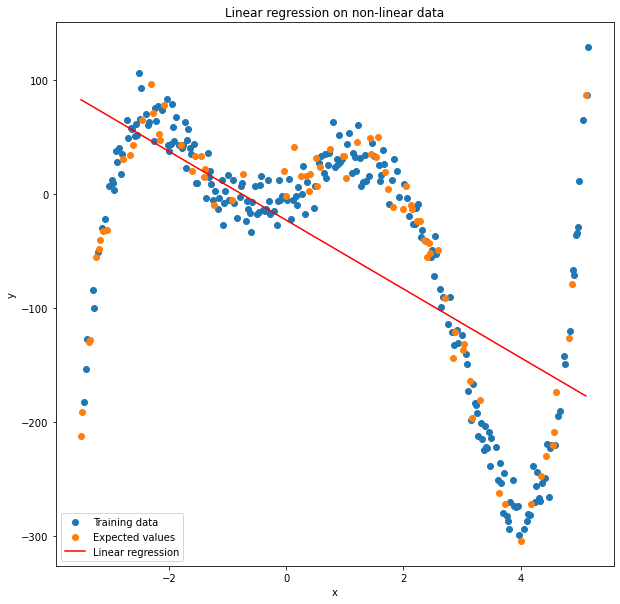

In [5]:
print(" ============ Split datasets ============")

seed = 666                    # Fix random seed for reproducibility
# Shuffle and split the data into train and a concatenation of validation and test sets
X02_train, X02_val_test, Y02_train, Y02_val_test = train_test_split(X02, Y02, 
                                                                    test_size=0.4, 
                                                                    shuffle=True, 
                                                                    random_state=seed)
seed = 221
# Shuffle and split the data into validation and test sets
X02_val, X02_test, Y02_val, Y02_test = train_test_split(X02_val_test, Y02_val_test, 
                                                        test_size=0.5, 
                                                        shuffle=True, 
                                                        random_state=seed)    

# sort with respect to x_axis for better plots
X02_train, Y02_train = sort_wrt_x_axis(X02_train, Y02_train)
X02_val, Y02_val = sort_wrt_x_axis(X02_val, Y02_val)
X02_test, Y02_test = sort_wrt_x_axis(X02_test, Y02_test)
print("Datapoints used for training:   ", len(Y02_train))
print("Datapoints used for validation: ", len(Y02_val))
print("Datapoints used for testing :   ", len(Y02_test))

print(" ============ Linear regression ============")
# ----------------------
# Training
# ----------------------
W = fit_LR(X02_train, Y02_train)
print("W_0 : %.2f" %W[0])
print("W_1 : %.2f" %W[1])
# ----------------------
# Evaluation
# ----------------------
Y02_pred = predict_LR(X02_val, W)
print("Mean Square Error: %.2f" %mean_squared_error(Y02_val, Y02_pred))
print('Coefficient of determination: %.2f' %r2_score(Y02_val, Y02_pred))
# ----------------------
# Plots
# ----------------------
plt.figure(figsize=(10,10))
plt.title("Linear regression on non-linear data")
plt.scatter(X02_train,Y02_train, label="Training data")
plt.scatter(X02_val,Y02_val, label="Expected values")
plt.plot(X02_val,Y02_pred, c="r", marker="", label="Linear regression")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### 3. Basis functions

#### 3.1 Linear regression with polynomial basis functions

From now on we will apply a non-linear transformation to ``X``, store the transformed data in a matrix ``phi`` and only then perform linear regression. 
This is called a linear basis functions model. 

In the lecture (slide 18), there is an example with a polynomial basis function $phi(x) = (1, x, x^2)$

Questions:

1. Function ``phi_polynomial``:
   1. complete this function taking the data ``X`` and a max degree ``d`` and returns ``phi`` containing the following matrix 
\begin{equation}
\Phi = 
\begin{bmatrix}
1 & x_{1} & x_{1}^2 & \cdots & x_{1}^d \\
1 & x_{2} & x_{2}^2 & \cdots & x_{2}^d \\
\vdots & \vdots  & \vdots  & \ddots & \vdots  \\
1 & x_{n} & x_{n}^2 & \cdots & x_{n}^d
\end{bmatrix} \in \mathbb{R}^{(n, d+1)}
\end{equation}
1. For all ``d`` in ``d_list``:
   1. Training:
      1. Compute ``phi_train`` by calling  ``phi_polynomial`` on your training data
      2. Compute ``W`` by calling ``fit_LR`` on your transformed data and your training set of  expected values
   2. Evaluation:
      1. Transform your validation data and store them in ``phi_val``
      2. Compute your predictions ``Y02_pred`` given your transformed validation data and your weights
      3. Look at how the mse was computed with the training data. Do the same with your validation data and store the mse in ``mse_val``
2. Interpretation:
   1. What do you obtain for ``d=0``?
   2. What do you obtain for ``d=1``? Compare with the cell above.
   3. By looking at the mse, which degree would you choose for your model?
   4. Models with a degree between 5 and 20 seem to work similarly. In the situation when several models of different complexity have approximately the same performance, what is usually the preferred option?
   5. For which values of ``d`` does the model seem to overfit?
   6. For ``d>16`` the performance on training data is getting worse. According to you, what could cause that?

 ============ Linear regression with polynomial basis functions ============


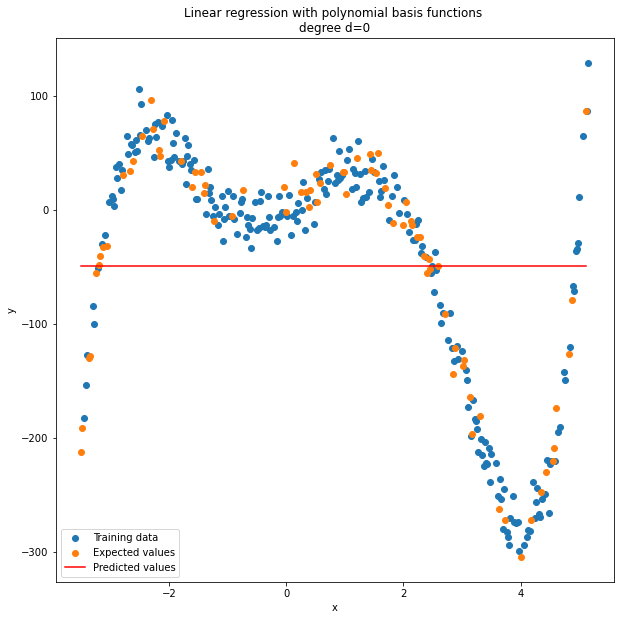

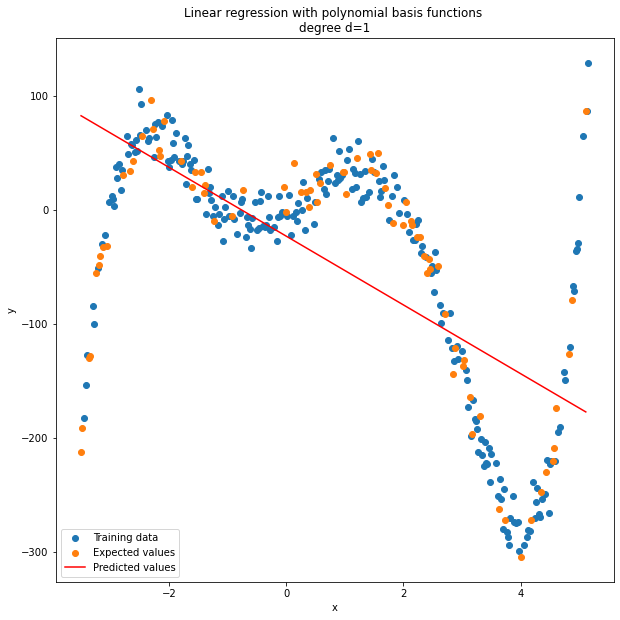

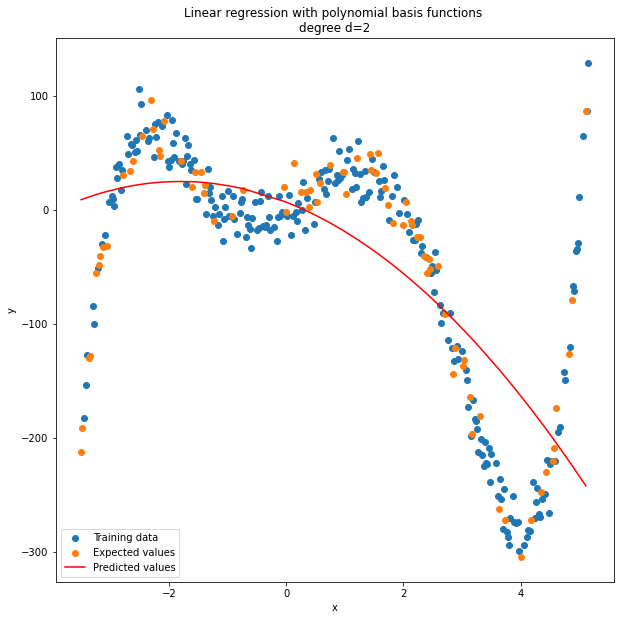

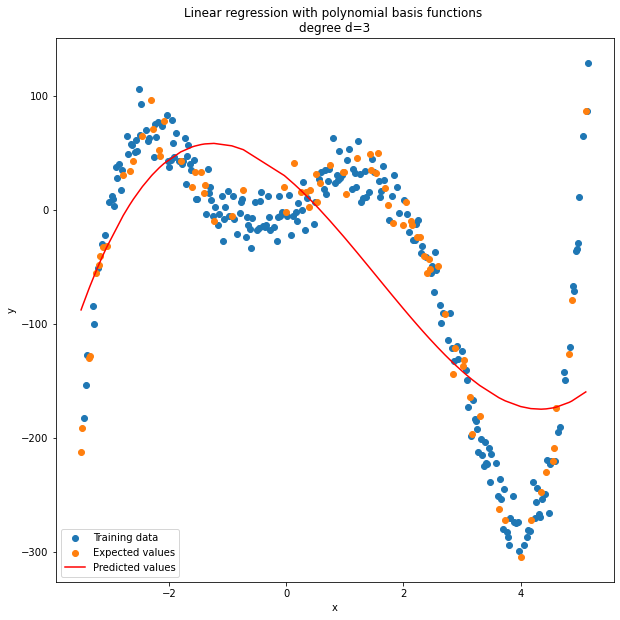

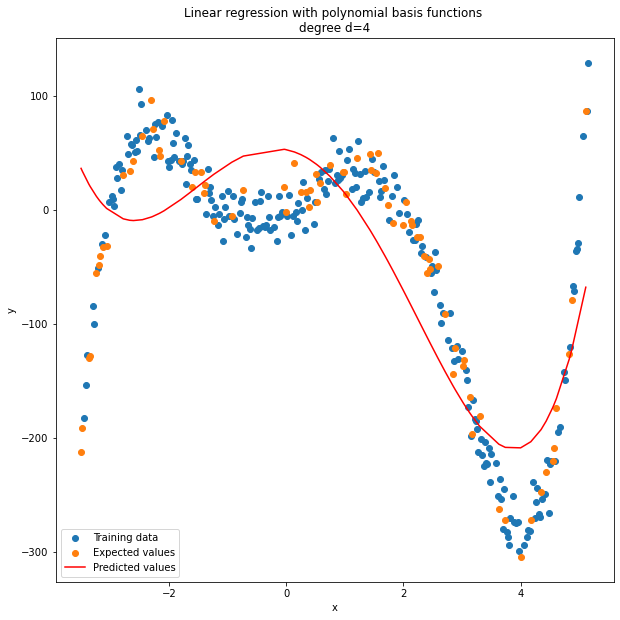

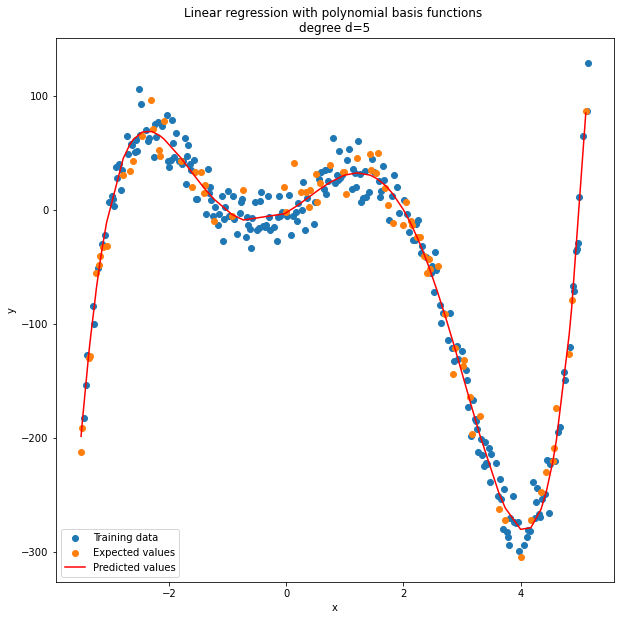

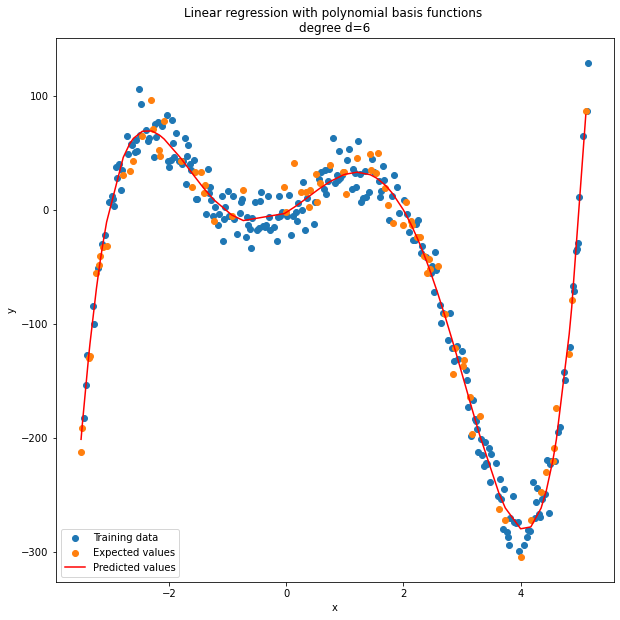

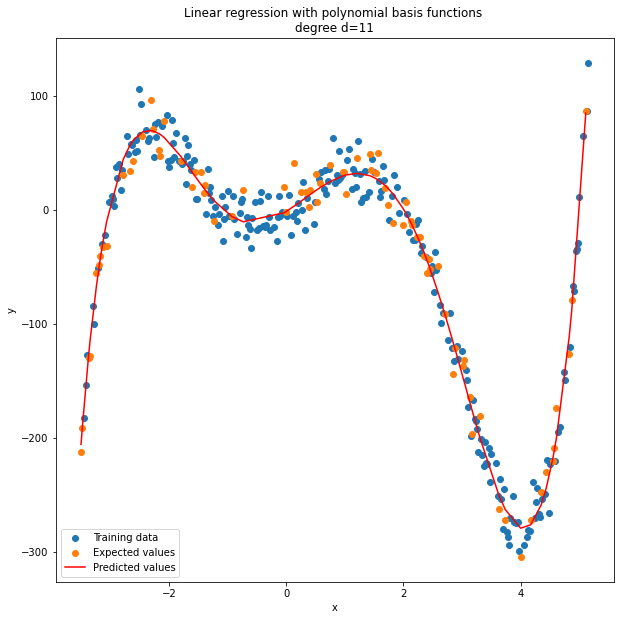

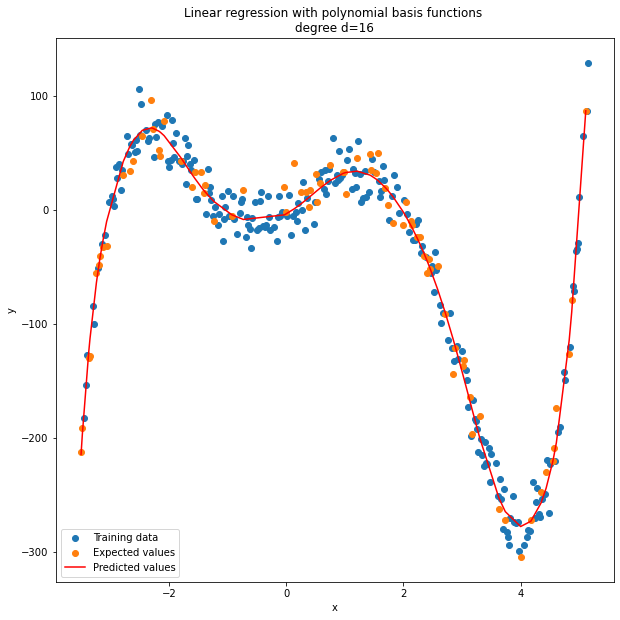

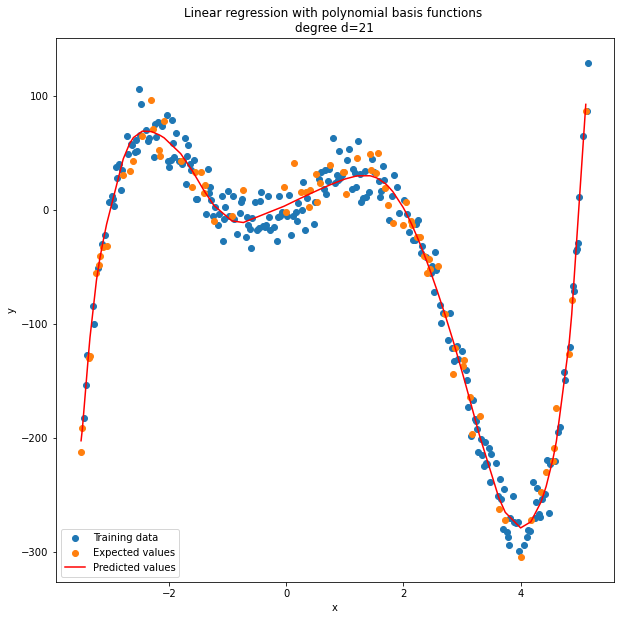

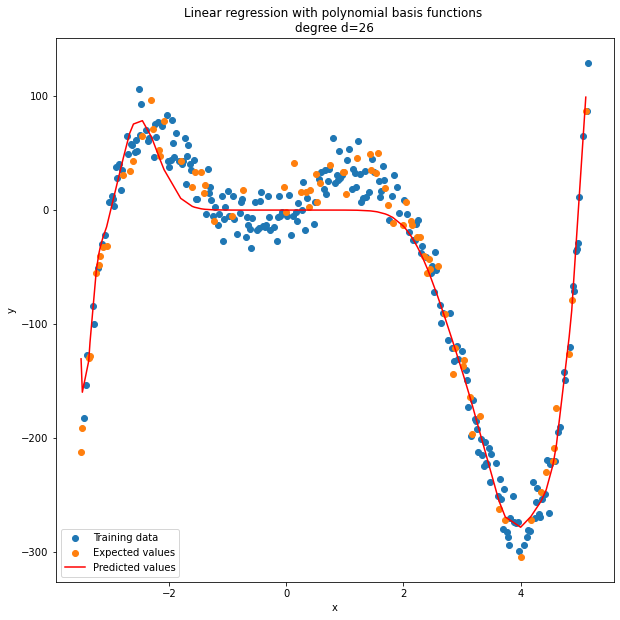

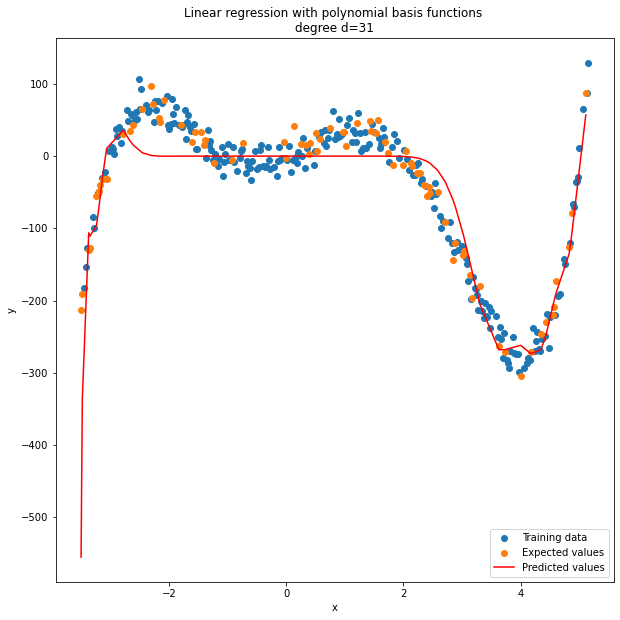

Text(0.5, 0, 'Max degree of the polynomial used as basis functions')

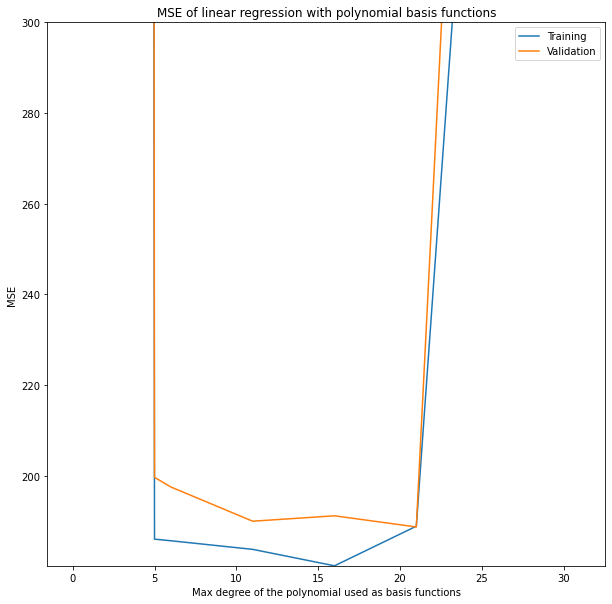

In [6]:
# ----------------------
# Polynomial basis functions
# ----------------------
def phi_polynomial(X,d):
    """
    Compute polynomial basis functions
    
    The biais is included in this function
    """
    phi = np.ones((len(X),d+1))
    for i in range(1,d+1):
        phi[:,i] = phi[:,i-1]*X
    return phi

print(" ============ Linear regression with polynomial basis functions ============")
mse_train = []
mse_val = []
d_list = list(range(6))+list(range(6,35,5))
for d in d_list:
    # ----------------------
    # Training
    # ----------------------
    phi_train = phi_polynomial(X02_train,d)
    #The biais is already included in phi
    W = fit_LR(phi_train,Y02_train, add_biais=False)  
    # ----------------------
    # Evaluation
    # ----------------------
    # Evaluate performance on training data
    #The biais is already included in phi
    Y02_pred_train = predict_LR(phi_train,W, add_biais=False)
    mse_train.append(mean_squared_error(Y02_train, Y02_pred_train))
    
    # Evaluate performance on validation data
    phi_val = phi_polynomial(X02_val,d)
    #The biais is already included in phi
    Y02_pred = predict_LR(phi_val,W, add_biais=False) 
    mse_val.append(mean_squared_error(Y02_val, Y02_pred))
    # ----------------------
    # Plots
    # ----------------------
    plt.figure(figsize=(10,10))
    plt.title("Linear regression with polynomial basis functions \ndegree d="+str(d))
    plt.scatter(X02_train,Y02_train, label="Training data")
    plt.scatter(X02_val,Y02_val, label="Expected values")
    plt.plot(X02_val,Y02_pred, c="r", marker="", label="Predicted values")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

# ----------------------
# Overview
# ----------------------
def plot_mse(x_axis, mse_train, mse_val):
    """
    Plot training and validation Mean Squared Error
    """
    plt.figure(figsize=(10,10))
    plt.ylim(min(min(mse_train),min(mse_val)), min(max(max(mse_train), max(mse_val)), 300))
    plt.plot(x_axis, mse_train, label="Training")
    plt.plot(x_axis, mse_val, label="Validation")
    plt.ylabel("MSE")
    plt.legend()


plot_mse(d_list, mse_train, mse_val)
plt.title("MSE of linear regression with polynomial basis functions")
plt.xlabel("Max degree of the polynomial used as basis functions")

#### 3.2 Linear regression with polynomial basis functions on non-polynomial data

1. Datasets 
   1. Split ``X03`` and ``Y03`` into 3 datasets, a training one, a validation one and a testing one with a ratio 0.6, 0.2, 0.2.
2. Polynomial basis functions using scikit-learn:
   1. Instantiate an object of the class [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn-linear-model-linearregression) from the scikit-learn library
   2. Train your model using your training dataset.
   3. Predict values using your model using your training dataset and then your validation dataset.
   4. Compute the MSE of your predictions on your validation data and store the successive values in ``mse_val``
   5. Plot training datapoints, expected datapoints from the validation dataset and your predictions
   6. Plot the MSE as a function of the max degree of the polynomial used as basis function
3. Interpretation:
   1. Does the model work well?
   2. Do you think polynomial functions are adapted to this problem?
   3. For ``d>20`` the performance on training data is getting worse. According to you, what could cause that?

 ============ Split datasets ============
Datapoints used for training:    300
Datapoints used for validation:  100
Datapoints used for testing :    100
 ============ Using scikit learn ============


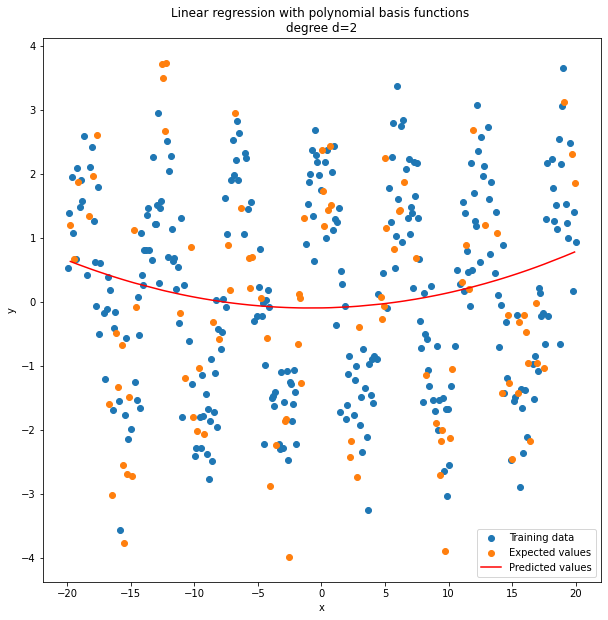

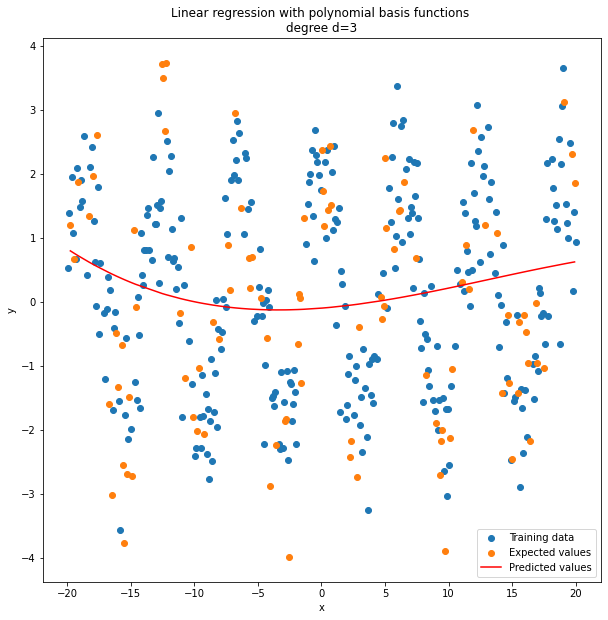

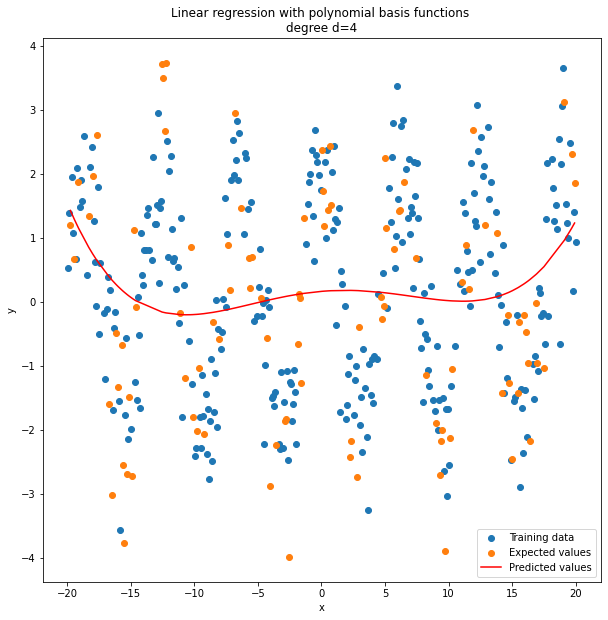

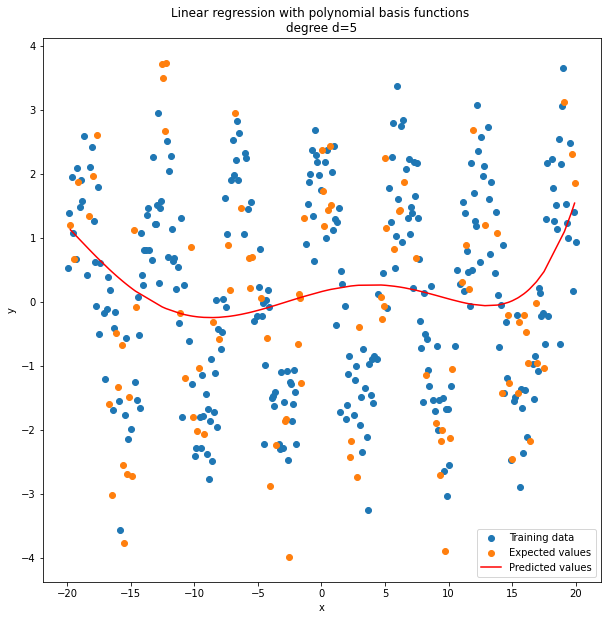

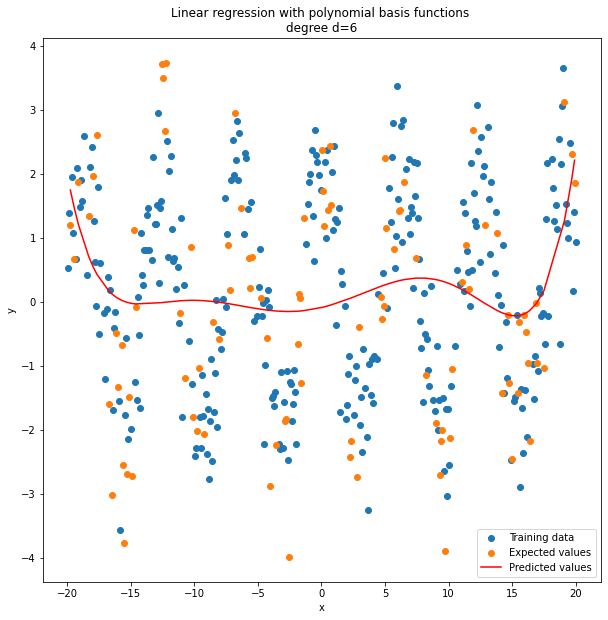

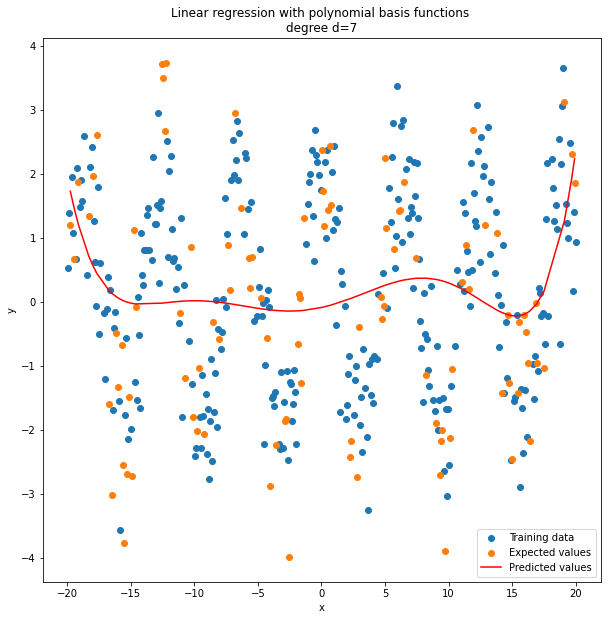

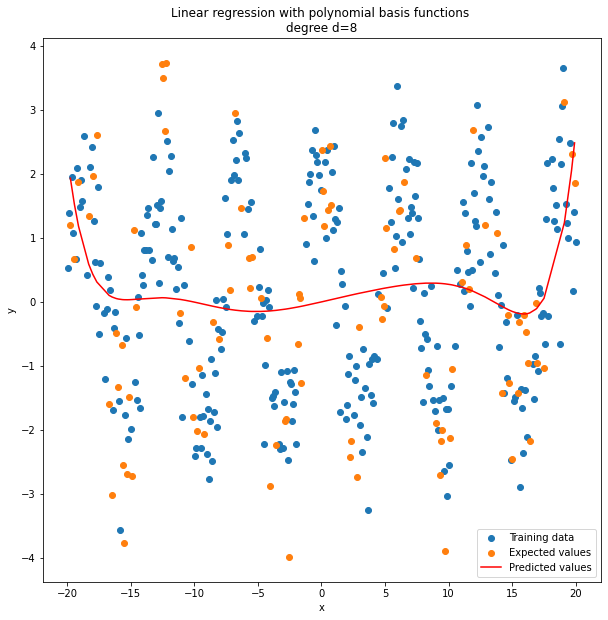

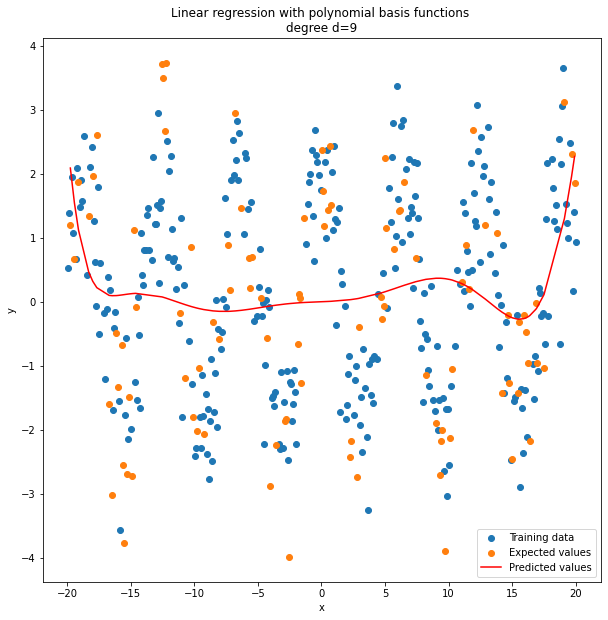

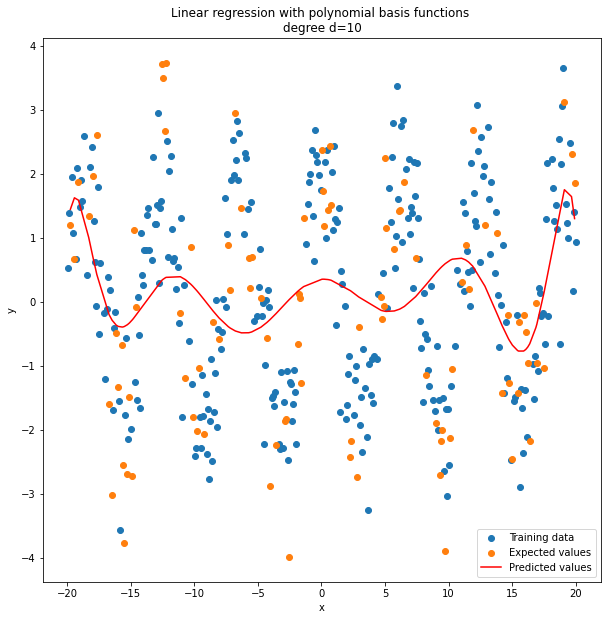

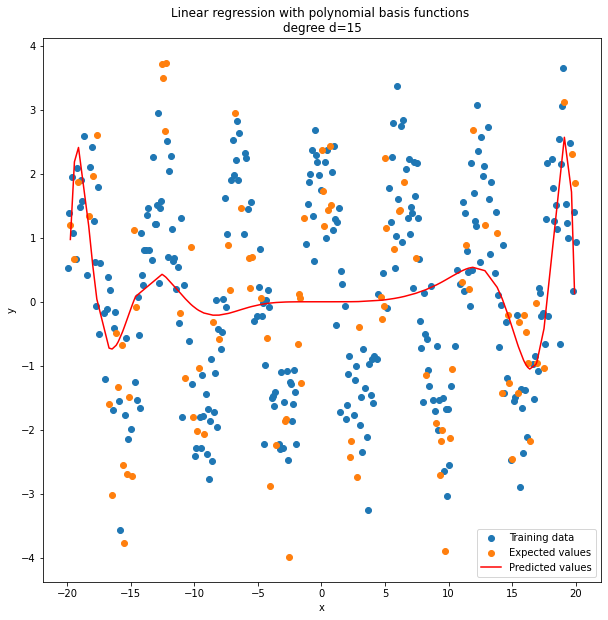

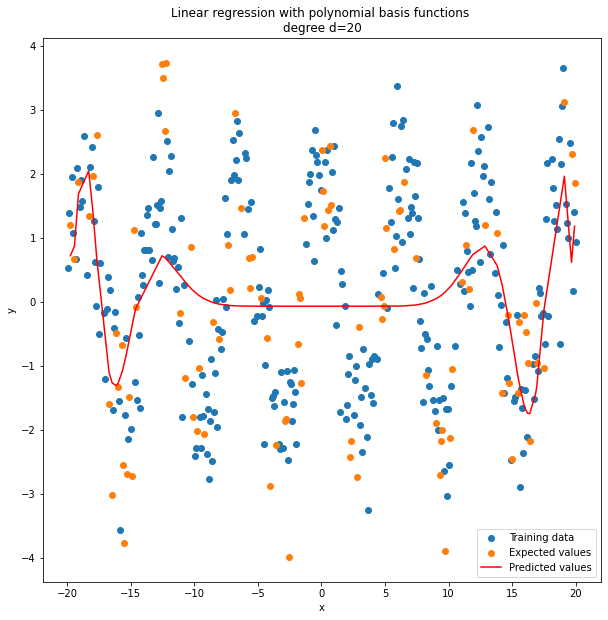

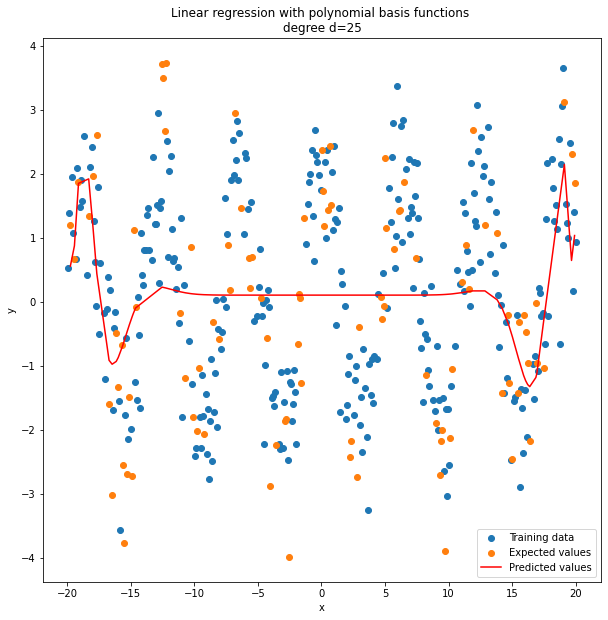

Text(0.5, 0, 'Max degree of the polynomial used as basis functions')

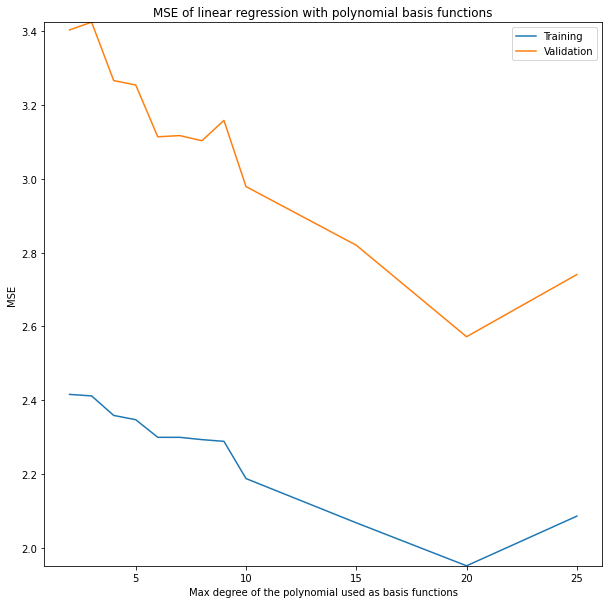

In [7]:
print(" ============ Split datasets ============")

seed = 666                    
# Shuffle and split the data into train and a concatenation of validation and test sets
X03_train, X03_val_test, Y03_train, Y03_val_test = train_test_split(X03, Y03, 
                                                                    test_size=0.4, 
                                                                    shuffle=True, 
                                                                    random_state=seed)
seed = 221
# Shuffle and split the data into validation and test sets
X03_val, X03_test, Y03_val, Y03_test = train_test_split(X03_val_test, Y03_val_test, 
                                                        test_size=0.5, 
                                                        shuffle=True, 
                                                        random_state=seed)    

# sort with respect to x_axis for better plots
X03_train, Y03_train = sort_wrt_x_axis(X03_train, Y03_train)
X03_val, Y03_val = sort_wrt_x_axis(X03_val, Y03_val)
X03_test, Y03_test = sort_wrt_x_axis(X03_test, Y03_test)
print("Datapoints used for training:   ", len(Y03_train))
print("Datapoints used for validation: ", len(Y03_val))
print("Datapoints used for testing :   ", len(Y03_test))

print(" ============ Using scikit learn ============")
mse_train = []
mse_val = []
d_list = list(range(2,10))+list(range(10,30,5))
for d in d_list:
    poly_model = make_pipeline(PolynomialFeatures(d),
                               LinearRegression())
    # ----------------------
    # Training
    # ----------------------
    # Use array.reshape(-1, 1) if your data has a single feature
    poly_model.fit(X03_train.reshape(-1, 1),Y03_train.reshape(-1, 1))
    # ----------------------
    # Evaluation
    # ----------------------
    # Evaluate performance on training data
    # Use array.reshape(-1, 1) if your data has a single feature
    y_pred_train = poly_model.predict(X03_train.reshape(-1, 1))
    mse_train.append(mean_squared_error(Y03_train, y_pred_train))
    
    # Evaluate performance on validation data
    y_pred_scikit = poly_model.predict(X03_val.reshape(-1, 1))
    mse_val.append(mean_squared_error(Y03_val, y_pred_scikit))
    # ----------------------
    # Plots
    # ----------------------
    plt.figure(figsize=(10,10))
    plt.title("Linear regression with polynomial basis functions \ndegree d="+str(d))
    plt.scatter(X03_train,Y03_train, label="Training data")
    plt.scatter(X03_val,Y03_val, label="Expected values")
    plt.plot(X03_val,y_pred_scikit, c="r", marker="", label="Predicted values")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()
    
# ----------------------
# Overview
# ----------------------
plot_mse(d_list, mse_train, mse_val)
plt.title("MSE of linear regression with polynomial basis functions")
plt.xlabel("Max degree of the polynomial used as basis functions")

Linear regression with cosine basis functions

Since the polynomial basis functions did not seem to work well on these data, we will use another type of basis function: cosine functions. To do so, we need to implement a new function ``phi_cosine`` that will transform our data ``X`` using cosine functions.

Questions:

1. Function ``phi_cosine``:
   1. Using [np.cos()](https://numpy.org/doc/stable/reference/generated/numpy.cos.html#numpy-cos), complete this function taking the data ``X`` and a number of cosine ``n_cosine`` and returns ``phi`` containing the following matrix 
\begin{equation}
\Phi = 
\begin{bmatrix}
1 & cos(x_{1}) & cos(2   x_{1}) & \cdots & cos(n_{cosine}   x_{1}) \\
1 & cos(x_{2}) & cos(2   x_{2}) & \cdots & cos(n_{cosine}   x_{2}) \\
\vdots & \vdots  & \vdots  & \ddots & \vdots  \\
1 & cos(x_{n}) & cos(2   x_{n}) & \cdots & cos(n_{cosine}   x_{n})
\end{bmatrix} \in \mathbb{R}^{(n, n_{cosine}+1)}
\end{equation}
1. Training
   1. Transform and fit your model using ``phi_cosine`` and ``fit_LR`` (Hint: look at what you did with polynomial functions)
2. Evaluation
   1. Use ``predict_LR`` on your training and validation datasets. 
   2. Compute and store your mean square errors in ``mse_train, mse_val``
3. Interpretation
   1. Does a cosine transformation seem to work better than a polynomial transformation on this data? 


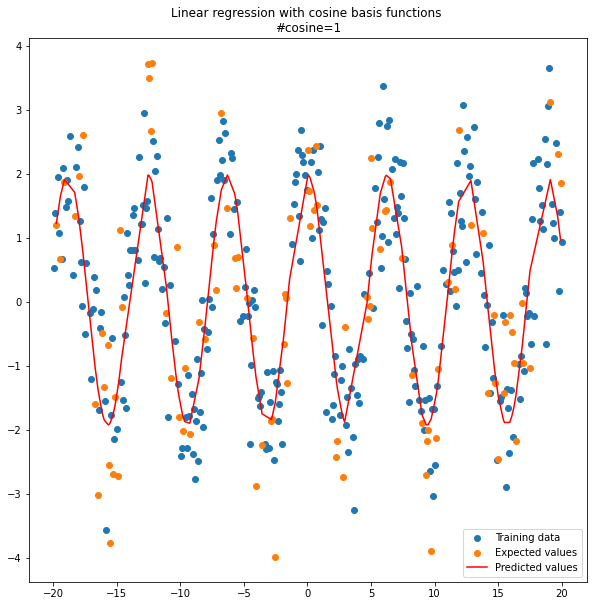

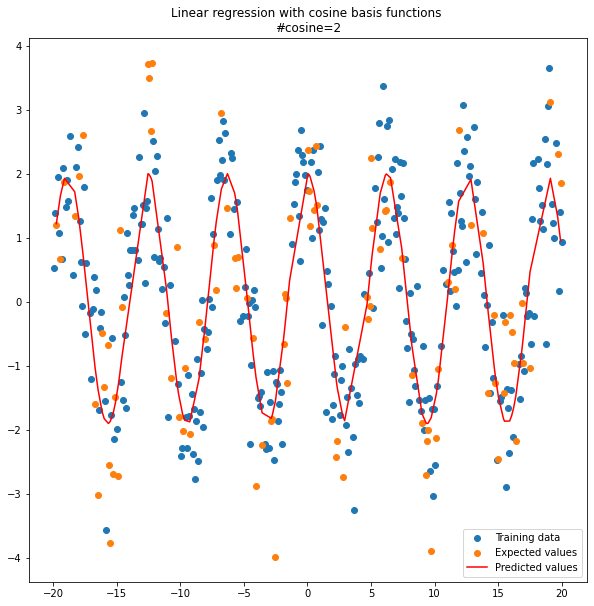

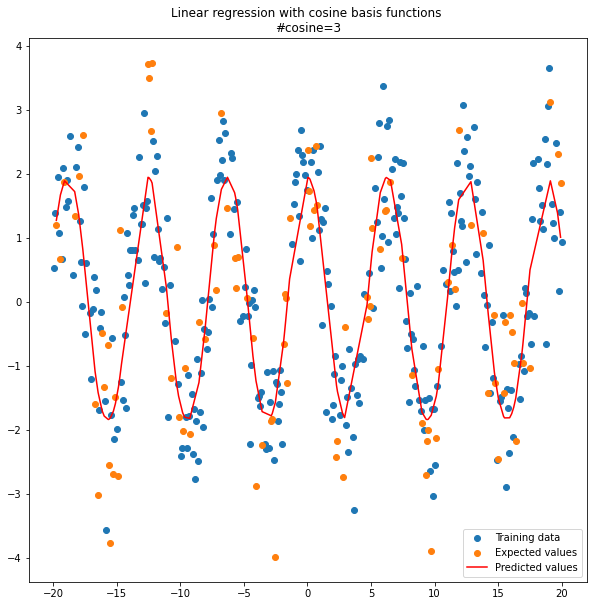

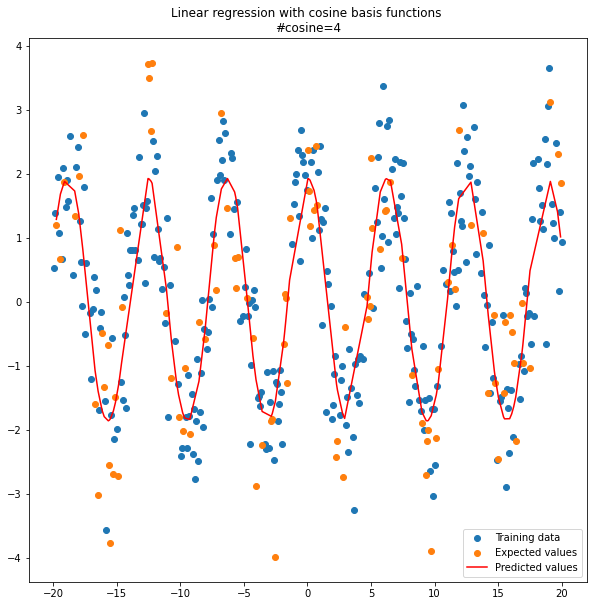

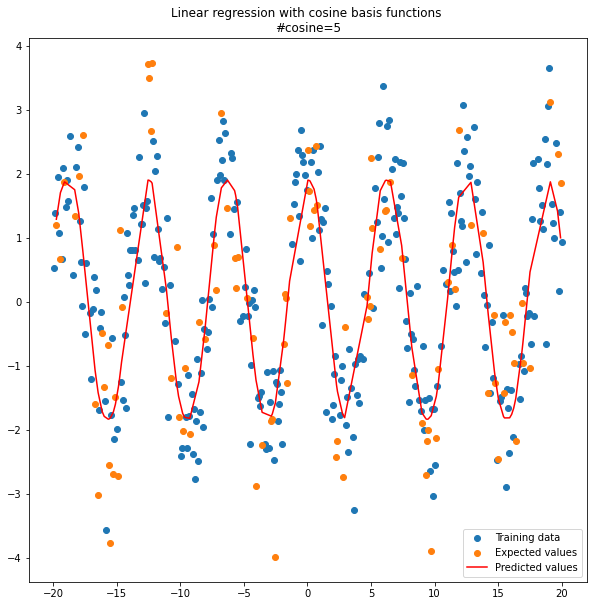

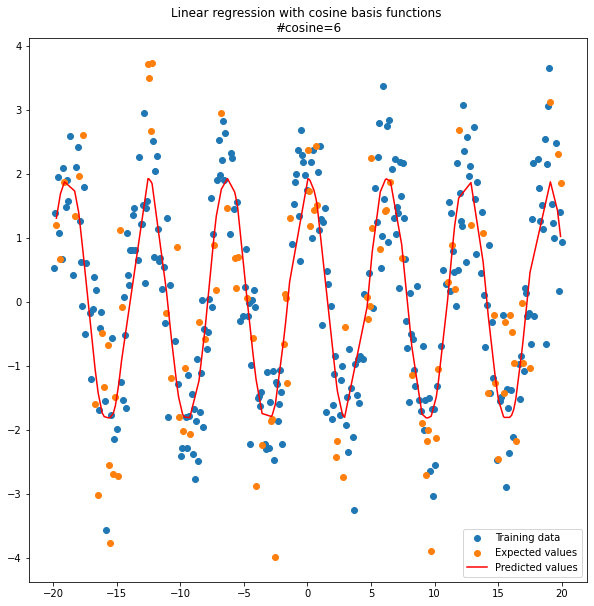

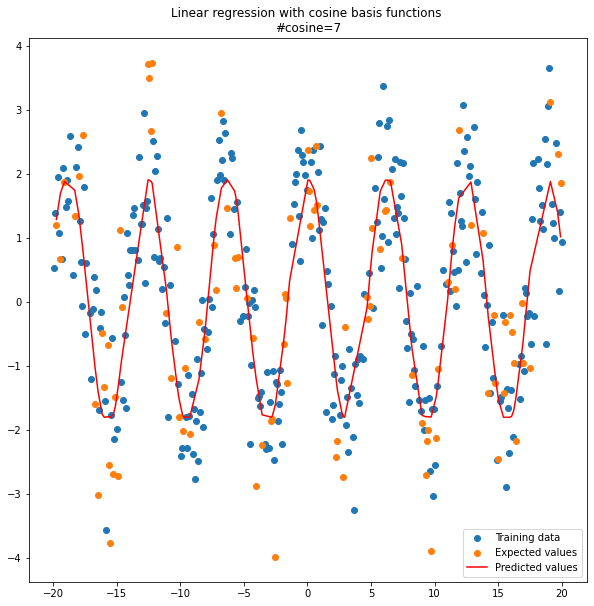

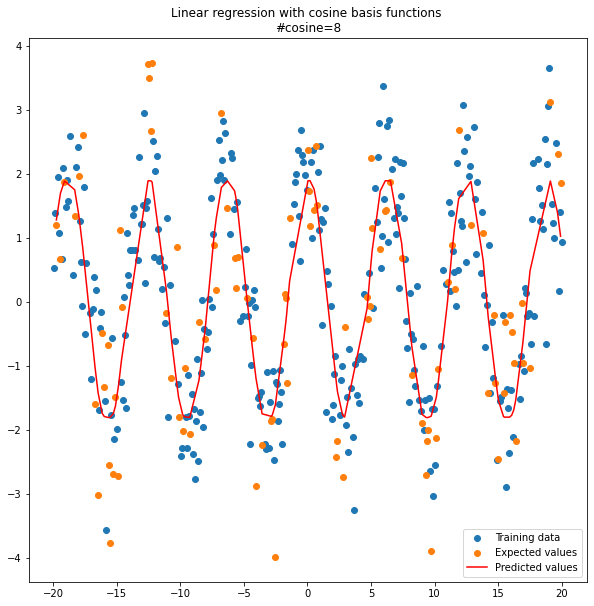

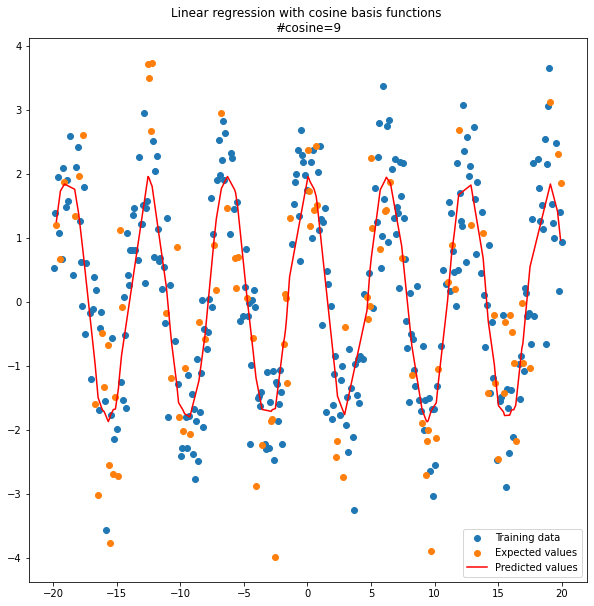

Text(0.5, 0, 'Number of cosine functions used')

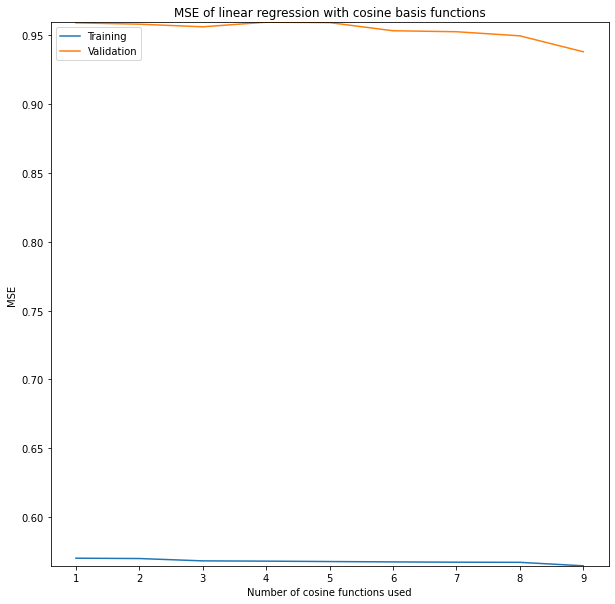

In [8]:
def phi_cosine(X,n_cosine):
    phi = np.ones((len(X),n_cosine+1))
    for i in range(1,n_cosine+1):
        phi[:,i] = np.cos(i*X)
    return phi

mse_train = []
mse_val = []
n_list = list(range(1,10))
for n in n_list:
    # ----------------------
    # Training
    # ----------------------
    phi_train = phi_cosine(X03_train,n)
    W = fit_LR(phi_train,Y03_train, add_biais=False)
    # ----------------------
    # Evaluation
    # ----------------------
    # Evaluate performance on training data
    Y03_pred_train = predict_LR(phi_train,W, add_biais=False)
    mse_train.append(mean_squared_error(Y03_train, Y03_pred_train))
    
    # Evaluate performance on validation data
    phi_val = phi_cosine(X03_val,n)
    Y03_pred = predict_LR(phi_val,W, add_biais=False)
    mse_val.append(mean_squared_error(Y03_val, Y03_pred))
    # ----------------------
    # Plots
    # ----------------------
    plt.figure(figsize=(10,10))
    plt.title("Linear regression with cosine basis functions \n#cosine="+str(n))
    plt.scatter(X03_train,Y03_train, label="Training data")
    plt.scatter(X03_val,Y03_val, label="Expected values")
    plt.plot(X03_val,Y03_pred, c="r", marker="", label="Predicted values")
    plt.legend()
    plt.show()
    
# ----------------------
# Overview
# ----------------------
plot_mse(n_list, mse_train, mse_val)
plt.title("MSE of linear regression with cosine basis functions")
plt.xlabel("Number of cosine functions used")

#### 3.4 Linear regression with gaussian basis functions


In the lecture (slide 19), there is an example with a gaussian basis function $$\Phi(x) = (e^{\epsilon(||\mathbf{x}-\mathbf{c}||)})$$

Where $\mathbf{c}$ is the center points

In the cell below we implemented ``phi_gaussian`` that works exactly as ``phi_polynomial`` and ``phi_cosine`` work.

Questions:

There are no questions for this one :) 

In [9]:
def phi_gaussian(X,n_gaussians, sigma=None):
    """
    Gaussian basis functions, uniformly spaced
    
    The biais is included in this function
    """
    phi = np.ones((len(X),n_gaussians+1))
    centers = np.linspace(X.min(), X.max(), n_gaussians)
    if sigma is None:
        if n_gaussians < 2:
            sigma = (X.max()-X.min())/2
        else:
            sigma = (centers[1]-centers[0])/2
    for i in range(1,n_gaussians+1):
        phi[:,i] = np.exp(-(X-centers[i-1])**2/sigma)
    return phi

### 4. Choose the right basis functions and the right parameters: model selection and evaluation

In this notebook you could observe that the performance of a given transformation (basis function) depends a lot on your problem (i.e your data) 

Then once the transformation is chosen, the complexity of your model (how many basis functions you have) influences the performance too. 

In this cell you will use a new dataset: ``X04, Y04``. You will need to split it as we did for the 3 other datasets and you will have to choose only one model (i.e one type of basis function and the number of basis functions).

You can choose among:

- simple linear regression (no transformation)
- polynomial basis functions
- cosine basis functions
- gaussian basis functions

We encourage you to try them all.

Then, for each type of transformation, tune your model parameters (which are ``d``, ``n_cosine``, ``n_gaussians`` here)

Finally select (automatically, not manually) the best model based on its validation error. You can store all the validation errors in a list, and then find the model with the lowest validation error.

#### 4.1 Model selection

 ============ Split datasets ============
Datapoints used for training:    240
Datapoints used for validation:  80
Datapoints used for testing :    80
 ============ Linear regression ============
W_0 : 0.21
W_1 : -0.03
 ============ Linear regression with polynomial basis functions ============


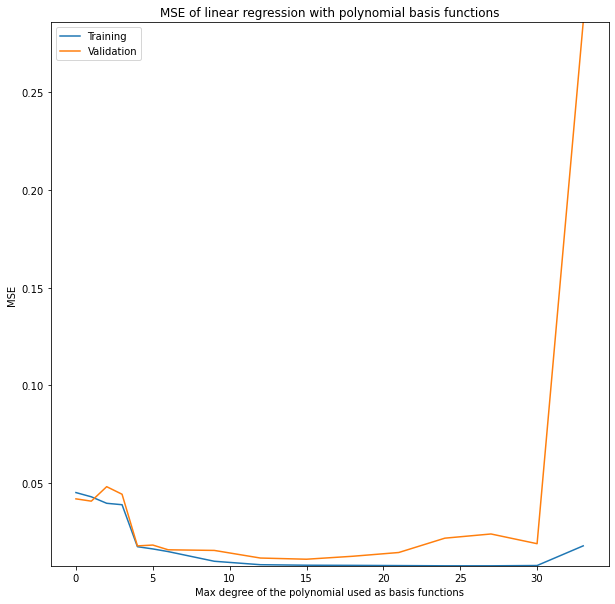

 ============ Linear regression with cosine basis functions ============


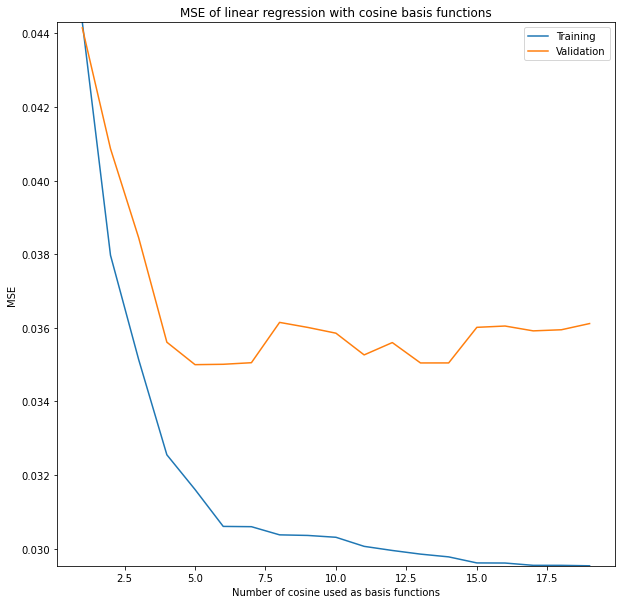

 ============ Linear regression with gaussian basis functions ============


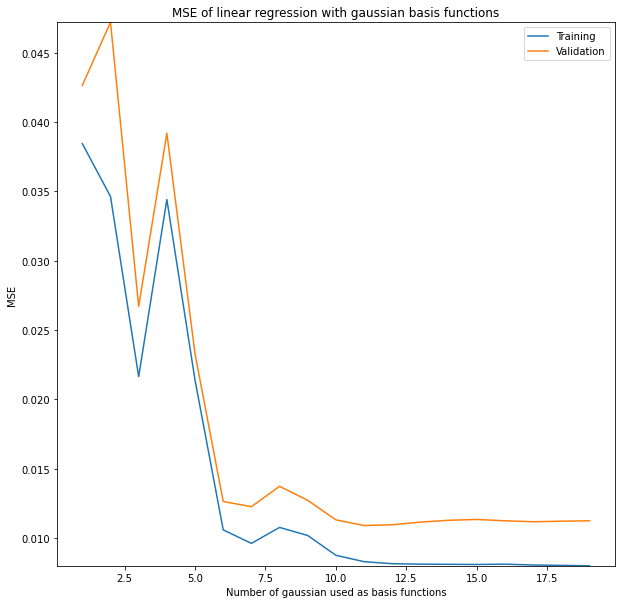

 ====== Selected model ====== 
The best model is with  Gaussian  tranformation, with parameter  11
Its validation MSE is:  0.010913000028793477


In [10]:
print(" ============ Split datasets ============")

seed = 666                    # Fix random seed for reproducibility
# Shuffle and split the data into train and a concatenation of validation and test sets
X04_train, X04_val_test, Y04_train, Y04_val_test = train_test_split(X04, Y04, 
                                                                    test_size=0.4, 
                                                                    shuffle=True, 
                                                                    random_state=seed)

seed = 221
# Shuffle and split the data into validation and test sets
X04_val, X04_test, Y04_val, Y04_test = train_test_split(X04_val_test, Y04_val_test, 
                                                        test_size=0.5, 
                                                        shuffle=True, 
                                                        random_state=seed)                                                                            

# sort with respect to x_axis for better plots
X04_train, Y04_train = sort_wrt_x_axis(X04_train, Y04_train)
X04_val, Y04_val = sort_wrt_x_axis(X04_val, Y04_val)
X04_test, Y04_test = sort_wrt_x_axis(X04_test, Y04_test)


# Store number of datapoints in each dataset:
N_train = len(Y04_train)
N_val = len(Y04_val)
N_test = len(Y04_test)
print("Datapoints used for training:   ", N_train)
print("Datapoints used for validation: ", N_val)
print("Datapoints used for testing :   ", N_test)

# For each type of transformation we will select the best MSE and parameters
transformation = ["None", "Polynomial", "Cosine", "Gaussian"]
best_mse_val = []
best_parameters = []

print(" ============ Linear regression ============")
# ----------------------
# Training
# ----------------------
W = fit_LR(X04_train, Y04_train)
print("W_0 : %.2f" %W[0])
print("W_1 : %.2f" %W[1])
# ----------------------
# Evaluation
# ----------------------
Y04_pred = predict_LR(X04_val, W)
mse_val = mean_squared_error(Y04_val, Y04_pred)

# ----------------------
# Temporary model selection (but there is no parameter, so no choice)
# ----------------------
best_mse_val.append(mse_val)
best_parameters.append("None")

print(" ============ Linear regression with polynomial basis functions ============")
mse_train = []
mse_val = []
d_list = list(range(6))+list(range(6,35,3))
for d in d_list:
    # ----------------------
    # Training
    # ----------------------
    phi_train = phi_polynomial(X04_train,d)
    #The biais is already included in phi
    W = fit_LR(phi_train,Y04_train, add_biais=False)  
    # ----------------------
    # Evaluation
    # ----------------------
    # Evaluate performance on training data
    Y04_pred_train = predict_LR(phi_train,W, add_biais=False) 
    mse_train.append(mean_squared_error(Y04_train, Y04_pred_train))
    
    # Evaluate performance on validation data
    phi_val = phi_polynomial(X04_val,d)
    Y04_pred = predict_LR(phi_val,W, add_biais=False) 
    mse_val.append(mean_squared_error(Y04_val, Y04_pred))

# ----------------------
# Overview
# ----------------------
plot_mse(d_list, mse_train, mse_val)
plt.title("MSE of linear regression with polynomial basis functions")
plt.xlabel("Max degree of the polynomial used as basis functions")
plt.show()

# ----------------------
# Temporary model selection
# ----------------------
i_best = np.argmin(mse_val)
best_mse_val.append(mse_val[i_best])
best_parameters.append(d_list[i_best])

print(" ============ Linear regression with cosine basis functions ============")

mse_train = []
mse_val = []
n_list = list(range(1,20))
for n in n_list:
    # ----------------------
    # Training
    # ----------------------
    phi_train = phi_cosine(X04_train,n)
    W = fit_LR(phi_train,Y04_train, add_biais=False)
    # ----------------------
    # Evaluation
    # ----------------------
    # Evaluate performance on training data
    Y04_pred_train = predict_LR(phi_train,W, add_biais=False)
    mse_train.append(mean_squared_error(Y04_train, Y04_pred_train))
    
    # Evaluate performance on validation data
    phi_val = phi_cosine(X04_val,n)
    Y04_pred = predict_LR(phi_val,W, add_biais=False)
    mse_val.append(mean_squared_error(Y04_val, Y04_pred))
    
# ----------------------
# Overview
# ----------------------
plot_mse(n_list, mse_train, mse_val)
plt.title("MSE of linear regression with cosine basis functions")
plt.xlabel("Number of cosine used as basis functions")
plt.show()
# ----------------------
# Temporary model selection
# ----------------------
i_best = np.argmin(mse_val)
best_mse_val.append(mse_val[i_best])
best_parameters.append(n_list[i_best])

print(" ============ Linear regression with gaussian basis functions ============")

mse_train = []
mse_val = []
n_list = list(range(1,20))
for n in n_list:
    # ----------------------
    # Training
    # ----------------------
    phi_train = phi_gaussian(X04_train,n)
    W = fit_LR(phi_train,Y04_train, add_biais=False)
    # ----------------------
    # Evaluation
    # ----------------------
    # Evaluate performance on training data
    Y04_pred_train = predict_LR(phi_train,W, add_biais=False)
    mse_train.append(mean_squared_error(Y04_train, Y04_pred_train))
    
    # Evaluate performance on validation data
    phi_val = phi_gaussian(X04_val,n)
    Y04_pred = predict_LR(phi_val,W, add_biais=False)
    mse_val.append(mean_squared_error(Y04_val, Y04_pred))
    
# ----------------------
# Overview
# ----------------------
plot_mse(n_list, mse_train, mse_val)
plt.title("MSE of linear regression with gaussian basis functions")
plt.xlabel("Number of gaussian used as basis functions")
plt.show()
# ----------------------
# Temporary model selection
# ----------------------
i_best = np.argmin(mse_val)
best_mse_val.append(mse_val[i_best])
best_parameters.append(n_list[i_best])

print(" ====== Selected model ====== ")
i_best = np.argmin(best_mse_val)
print("The best model is with ", transformation[i_best], " tranformation, with parameter ", best_parameters[i_best])
print("Its validation MSE is: ", best_mse_val[i_best] )

#### 4.2 Model evaluation

Evaluate the performance of your selected model by computing its MSE error on the testing dataset

Training MSE:     0.0083
Validation MSE:   0.0109
Test MSE:         0.0104


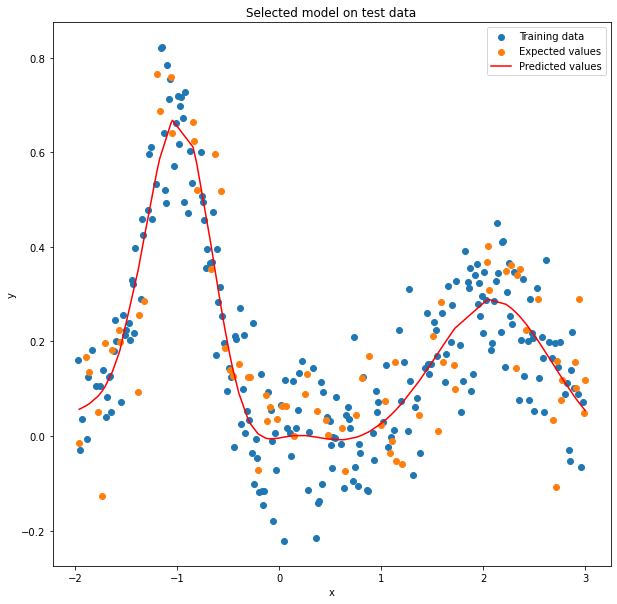

In [11]:
n = best_parameters[i_best]
# ----------------------
# Training
# ----------------------
phi_train = phi_gaussian(X04_train,n)
W = fit_LR(phi_train, Y04_train, add_biais=False)
# ----------------------
# Evaluation
# ----------------------
# Evaluate performance on training data
Y04_pred_train = predict_LR(phi_train,W, add_biais=False)
mse_train = mean_squared_error(Y04_train, Y04_pred_train)

# Evaluate performance on validation data
phi_val = phi_gaussian(X04_val,n)
Y04_pred = predict_LR(phi_val,W, add_biais=False)
mse_val = mean_squared_error(Y04_val, Y04_pred)

# Evaluate performance on test data
phi_test = phi_gaussian(X04_test,n)
Y04_pred = predict_LR(phi_test, W, add_biais=False)
mse_test = mean_squared_error(Y04_test, Y04_pred)

print("Training MSE:     %.4f" %mse_train)
print("Validation MSE:   %.4f" %mse_val)
print("Test MSE:         %.4f" %mse_test)

# ----------------------
# Plots
# ----------------------
plt.figure(figsize=(10,10))
plt.title("Selected model on test data")
plt.scatter(X04_train,Y04_train, label="Training data")
plt.scatter(X04_test,Y04_test, label="Expected values")
plt.plot(X04_test,Y04_pred, c="r", marker="", label="Predicted values")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
